# Part 1: Deriving Derivatives on Triangular Grid

_To run this script you need output from [Selecting and Reindexing of Area of Interest](../cutting_grid_window.ipynb)._

## Theoretical Introduction

Since we are working on a grid whitout any right angles, we have to come up with something new to calculate gradients or derivatives. <br>
Basically, the idea is this: We do a local two-dimensional Taylor evolution for a cell $i$, giving us a plane equation containing 3 unknowns. If we apply this plane equation to three points (here the three neighbors) in the neighborhood of the cell $i$, the equation can be solved. This procedure can be applied in matrix form to all cells simultaneously and thus calculate the derivative for a certain area in one go.

To look at this from a mathematical point of view, we make use of linear algebra: if you have the coordinates of three points, you can use them to create a plane and thus a linear system of equations. <br>
This has the form:

$$\underline{\underline{A}}~ \underline{\phi} = \underline{p}.$$

If the matrix $\underline{\underline{A}}$ is square and has full rank, then the system has a unique solution given by:

$$\underline{\phi} = \underline{\underline{A}}^{-1}~\underline{p},$$
where $\underline{\underline{A}}^{-1}$ is the inverse of $\underline{\underline{A}}$. (For matrices which are not square or of  full rank the Moore-Penrose pseudoinverse can help here, and possibly be used to generalize this code.)

We reach the respective centers of the neighboring cells via their coordinates and write down the equations in parametric form of a plane:

$$
\begin{matrix}
\alpha(x_0, y_0) + \beta (x_1-x_0) + \gamma (y_1-y_0) = p_1(x_1, y_1)\\
\alpha(x_0, y_0) + \beta (x_2-x_0) + \gamma (y_2-y_0) = p_2(x_2, y_2)\\
\alpha(x_0, y_0) + \beta (x_3-x_0) + \gamma (y_3-y_0) = p_3(x_3, y_3)
\end{matrix}
$$

Perhaps you can already see the practical use of this approach; the derivative with respect to $x_i$ or $y_i$, with $i \in \{1,2,3\}$ results in the coefficients $\beta$ or $\gamma$:

$$\frac{\partial p_i}{\partial x_i} = \beta ~~\text{and}~~ \frac{\partial p_j}{\partial y_j} = \gamma$$
This means that we have to calculate these coefficients to get the derivatives of the corresponding variable.

We write down our equations in matrix notation:

$$
\underbrace{
\begin{bmatrix}
1 & (x_1-x_0) & (y_1-y_0)\\
1 & (x_2-x_0) & (y_2-y_0)\\
1 & (x_3-x_0) & (y_3-y_0)
\end{bmatrix}}_{\underline{\underline{A}}}
\underbrace{
\begin{bmatrix}
\alpha\\
\beta\\
\gamma
\end{bmatrix}}_{\underline{\phi}}
=
\underbrace{
\begin{bmatrix}
p_1(x_1, y_1)\\
p_2(x_2, y_2)\\
p_3(x_3, y_3)
\end{bmatrix}}_{\underline{p}}
$$

As a final step, we calculate the inverse of $\underline{\underline{A}}$ and automatically obtain the coefficients $\alpha, \beta, \gamma$ by calculating the matrix product $$\underline{\phi} = \underline{\underline{A}}^{-1}~\underline{p}.$$

Let's get our hands dirty now!

In [1]:
import xarray as xr
import numpy as np

## Deriving Derivatives

The individual output variables of the ICON simulations do not contain any coordinates apart from the height (only in 3D output) and the time. Therefore it is necessary to get the coordinates from the grid-file. <br>
We have created a `new_grid` via the [Selecting and Reindexing of Area of Interest](../cutting_grid_window.ipynb) script, which contains the same information as the global grid-file focused on our area of interest with the advantage of being smaller and easier to handle.

Range of area of interest:

In [2]:
# Max Plancks birthplace, Kiel, Schleswig-Holstein, Germany
left_bound = 9.88
right_bound = 10.38
top_bound = 54.57
bottom_bound = 54.07

We import the `selected_indices`, hence the indices for `cells`, `vertices` and `edges`, just like the `new_grid` which contains the grid information of the area of interest.

In [3]:
selected_indices = xr.open_dataset(
    f"selected_indices_region_{bottom_bound}-{top_bound}_{left_bound}-{right_bound}.nc"
)
new_grid = xr.open_dataset(
    f"new_grid_region_{bottom_bound}-{top_bound}_{left_bound}-{right_bound}.nc"
)

new_grid

<xarray.Dataset>
Dimensions:                         (cell: 70, nv: 3, vertex: 50, ne: 6,
                                     edge: 119, no: 4, nc: 2,
                                     max_stored_decompositions: 4, two_grf: 2,
                                     cell_grf: 14, max_chdom: 1, edge_grf: 24,
                                     vert_grf: 13)
Coordinates:
    clon                            (cell) float64 ...
    clat                            (cell) float64 ...
    vlon                            (vertex) float64 ...
    vlat                            (vertex) float64 ...
    elon                            (edge) float64 ...
    elat                            (edge) float64 ...
  * cell                            (cell) int64 4282376 4282377 ... 4283130
  * vertex                          (vertex) int32 2144929 2144932 ... 2145286
  * edge                            (edge) int32 6427302 6427311 ... 6428420
Dimensions without coordinates: nv, ne, no, nc, max_stored_decompositions,
                                two_grf, cell_grf, max_chdom, edge_grf, vert_grf
Data variables: (12/91)
    clon_vertices                   (cell, nv) float64 ...
    clat_vertices                   (cell, nv) float64 ...
    vlon_vertices                   (vertex, ne) float64 ...
    vlat_vertices                   (vertex, ne) float64 ...
    elon_vertices                   (edge, no) float64 ...
    elat_vertices                   (edge, no) float64 ...
    ...                              ...
    edge_dual_normal_cartesian_x    (edge) float64 ...
    edge_dual_normal_cartesian_y    (edge) float64 ...
    edge_dual_normal_cartesian_z    (edge) float64 ...
    cell_circumcenter_cartesian_x   (cell) float64 ...
    cell_circumcenter_cartesian_y   (cell) float64 ...
    cell_circumcenter_cartesian_z   (cell) float64 ...
Attributes: (12/43)
    title:                    ICON grid description
    institution:              Max Planck Institute for Meteorology/Deutscher ...
    source:                   git@git.mpimet.mpg.de:GridGenerator.git
    revision:                 d00fcac1f61fa16c686bfe51d1d8eddd09296cb5
    date:                     20180529 at 222250
    user_name:                Rene Redler (m300083)
    ...                       ...
    topography:               modified SRTM30
    subcentre:                1
    number_of_grid_used:      15
    history:                  Thu Aug 16 11:05:44 2018: ncatted -O -a ICON_gr...
    ICON_grid_file_uri:       http://icon-downloads.mpimet.mpg.de/grids/publi...
    NCO:                      netCDF Operators version 4.7.5 (Homepage = http...

Since this is an example of Max Planck's birthplace, let's take a look at how the pressure on his birthday in 2020 behaves within the region where he spent his first hours of life, so the dark green area from the script [Selecting and Reindexing of Area of Interest](../cutting_grid_window.ipynb). For this purpose we access the pressure `pfull` of the Dyamond dpp0029 simulation. The output will be the whole globe at this point.

In [4]:
max_birthday_data = xr.open_dataset(
    "/work/mh0287/k203123/Dyamond++/icon-aes-dyw2/experiments/dpp0029/dpp0029_atm_3d_1_ml_20200423T000000Z.nc"
)
pfull = max_birthday_data.pfull
pfull

<xarray.DataArray 'pfull' (time: 1, height: 90, ncells: 20971520)>
[1887436800 values with dtype=float32]
Coordinates:
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 86.0 87.0 88.0 89.0 90.0
  * time     (time) float64 2.02e+07
Dimensions without coordinates: ncells
Attributes:
    standard_name:                air_pressure
    long_name:                    Pressure
    units:                        Pa
    param:                        0.3.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

But as we only want the area around his birthplace in Kiel, we select via `.isel(ncells = selected_indices.cell)` only the cells in the area of interest. Furthermore we average in time and choose the first 10 heightlevels from the atmosphere - land/ocean surface upwards (the z-vector in the ICON simulations points to the interior of the earth, i.e. to the surface of the earth, so that the level closest to the earth has the index `90` and we thus run from `81-90`).
<br>

The next step requires a relatively large amount of memory for various reasons. It is therefore advisable to use about 32GB at this point and save the result to use in later calculations.

In [5]:
pfull = (
    pfull.mean(dim="time")
    .isel(ncells=selected_indices.cell)
    .sel({"height": slice(81, 90)})
)
pfull

<xarray.DataArray 'pfull' (height: 10, cell: 70)>
array([[ 89579.93 ,  89524.6  ,  89488.8  ,  89601.09 ,  89637.8  ,
         89505.664,  89588.016,  89515.9  ,  89455.82 ,  89628.78 ,
         89769.734,  89697.72 ,  89747.2  ,  89601.88 ,  89620.94 ,
         89537.88 ,  89568.84 ,  89619.6  ,  89473.53 ,  89578.05 ,
         89530.805,  89863.78 ,  89874.59 ,  89801.36 ,  89865.234,
         89873.83 ,  89874.29 ,  89878.98 ,  89876.27 ,  89785.62 ,
         89815.086,  89723.125,  89753.766,  89685.4  ,  89664.7  ,
         89672.19 ,  89590.06 ,  89466.48 ,  89633.836,  89566.055,
         89569.05 ,  89584.96 ,  89607.36 ,  89586.35 ,  89625.45 ,
         89485.46 ,  89533.4  ,  89723.61 ,  89655.95 ,  89720.44 ,
         89754.84 ,  89648.88 ,  89516.305,  89732.47 ,  89718.28 ,
         89825.27 ,  89695.81 ,  89882.02 ,  89862.805,  89879.836,
         89692.67 ,  89654.26 ,  89836.68 ,  89712.78 ,  89724.66 ,
         89881.46 ,  89886.16 ,  89770.2  ,  89740.29 ,  89750.305],
       [ 91697.42 ,  91636.45 ,  91596.43 ,  91717.51 ,  91757.08 ,
         91612.414,  91704.62 ,  91624.65 ,  91559.664,  91747.234,
         91900.195,  91821.46 ,  91874.39 ,  91716.66 ,  91740.4  ,
         91648.15 ,  91683.46 ,  91739.58 ,  91580.266,  91695.84 ,
         91642.55 ,  92001.88 ,  92012.78 ,  91934.52 ,  92003.15 ,
         92011.06 ,  92011.81 ,  92015.88 ,  92013.9  ,  91915.88 ,
...
        101646.22 , 101715.98 , 102000.59 , 101901.94 , 101991.586,
        102043.75 , 101875.74 , 101698.97 , 101997.73 , 101980.17 ,
        102144.83 , 101936.79 , 102235.68 , 102205.15 , 102234.97 ,
        101932.21 , 101877.91 , 102163.36 , 101973.68 , 101991.84 ,
        102228.2  , 102237.72 , 102058.66 , 102013.766, 102033.27 ],
       [102309.24 , 102219.92 , 102155.516, 102326.03 , 102382.24 ,
        102168.05 , 102313.945, 102194.7  , 102103.3  , 102368.69 ,
        102579.664, 102468.74 , 102534.625, 102313.586, 102361.57 ,
        102221.02 , 102278.79 , 102365.4  , 102133.664, 102308.28 ,
        102222.21 , 102722.5  , 102731.53 , 102631.77 , 102719.91 ,
        102719.28 , 102722.78 , 102720.305, 102726.414, 102594.2  ,
        102638.445, 102489.87 , 102553.766, 102450.336, 102398.12 ,
        102403.766, 102294.336, 102106.266, 102357.83 , 102246.2  ,
        102257.36 , 102266.836, 102310.47 , 102292.81 , 102346.68 ,
        102137.52 , 102208.1  , 102495.82 , 102396.266, 102486.766,
        102539.   , 102368.85 , 102190.805, 102492.61 , 102475.08 ,
        102641.555, 102430.74 , 102734.87 , 102702.695, 102734.59 ,
        102426.09 , 102371.79 , 102660.34 , 102468.66 , 102487.75 ,
        102726.49 , 102736.54 , 102553.94 , 102508.5  , 102528.7  ]],
      dtype=float32)
Coordinates:
  * height   (height) float64 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0
  * cell     (cell) int64 4282376 4282377 4282378 ... 4283128 4283129 4283130

Before we start with our calculations, let's first look at the surface field of the pressure. For this we use [matplotlib.pyplot.tripcolor()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tripcolor.html), which we have used [here](../tripcolor.ipynb) before, because it can be used to represent triangular grids very nicely.

In [6]:
%matplotlib inline
import matplotlib.pylab as plt

To make this plot we need information from the `new_grid` file, namely the vertices of each cell `.vertex_of_cell` which again lives in the 1-based Fortran world, so we compensate the index offset by subtracting `1` in `voc`.

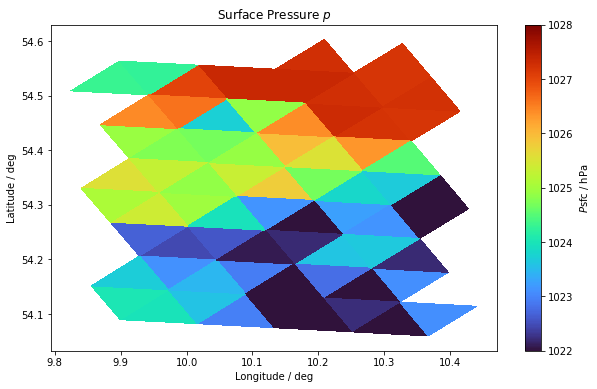

In [7]:
heightlevel = 90

vlon = np.rad2deg(new_grid.vlon)
vlat = np.rad2deg(new_grid.vlat)
voc = new_grid.vertex_of_cell.T.values - 1
p_data = pfull.sel(height=heightlevel).values / 100  ### in [hPa]

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.tripcolor(
    vlon, vlat, voc, p_data, cmap=plt.cm.get_cmap("turbo"), vmin=1022, vmax=1028
)
cbar = fig.colorbar(im)

cbar.set_label("$P\mathrm{sfc}$ / hPa")
ax.set_title(r"Surface Pressure $p$")
ax.set_xlabel("Longitude / deg")
ax.set_ylabel("Latitude / deg")

plt.show()

### Derivatives

Now to the core of this script and to the interpretation of what we described in the [Theoretical Introduction](#Theoretical-Introduction) into code. Since we are interested in derivatives on the triangular grid, we want to calculate the pressure gradient along both the x and y directions as an example at this point.
<br>

Within the function `derivative()` we find 5 paragraphs:

In the **first paragraph**, we consider the neighbors of each cell, because the idea is to span a plane over the central initial cell with their help and to determine the derivative for the central cell in x- and y-direction by means of the slope of this plane.<br>
However, this reduces the initial set of cells to those that have 3 neighbors. The cells that are at the edge of our cut out area do not necessarily have 3 neighbors and are neglected here; the area shrinks a little. Only ```valid```cells within 3 neighbors are choosen.

The **second paragraph**, is used to identify the respective coordinates.

The **third paragraph**, outputs the pressure values for the valid cells.

In the **fourth** and **fifth paragraphs** happens what we described mathematically at the [beginning](#Theoretical-Introduction). <br>
We set up a system of equations in matrix form and solve it via matrix inversion. Finally, we output the coefficients and a boolean array of the valid cells and we are done!

In [8]:
def derivative(grid, data):
    neighbors = (grid.neighbor_cell_index.values - 1).T
    valid = np.all(neighbors >= 0, axis=-1)

    cell_lon = np.rad2deg(new_grid.clon.values[valid])
    cell_lat = np.rad2deg(new_grid.clat.values[valid])
    neighbors_lon = np.rad2deg(new_grid.clon.values[neighbors[valid]])
    neighbors_lat = np.rad2deg(new_grid.clat.values[neighbors[valid]])

    p = data.values[..., neighbors[valid]]
    ones = np.ones_like(neighbors_lon)
    A = np.stack(
        (
            ones,
            neighbors_lon - cell_lon[:, np.newaxis],
            neighbors_lat - cell_lat[:, np.newaxis],
        ),
        axis=2,
    )
    A_inv = np.linalg.inv(A)

    alpha, beta, gamma = np.einsum("...ij,...j->i...", A_inv, p)

    return alpha, beta, gamma, valid

We apply our defined function `derivative()` to our `new_grid` and the pressure `pfull` and we get $\alpha, \beta, \gamma$ which we identified as $p_0, \frac{\partial p}{\partial lon}, \frac{\partial p}{\partial lat}$. These are defined at the centroid of the points $p_1, p_2, p_3$, which we used to construct the linear equation system. The centroid of the triangle spanned by the centers of the neighboring cells lies approximately (but to a good approximation) on the center of the cell for which we wanted to calculate the derivative. <br>

By substracting the coordinates of each center cell from the coordinates of the corresponding neighbor cells within our matrix $A$, we obtain the relative difference in lat/lon direction of the central cell to its neighbors. By doing this $p_0$ corresponds to the averaged pressure value based on the neighbors cell pressure values.

In [9]:
p0, dpdlon, dpdlat, valid = derivative(new_grid, pfull)

Let's look at what the pressure gradient field looks like on the surface.<br>
We notice that we are looking at a small area, since the cells that do not have exactly 3 neighbors were not included in the calculation.

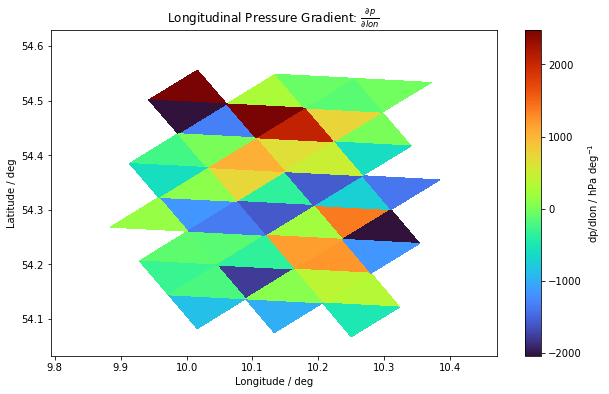

In [10]:
dvlon = np.rad2deg(new_grid.vlon)
dvlat = np.rad2deg(new_grid.vlat)
dvoc = voc[valid]  ### choosing only the cells with 3 neighbors
dpdlon_sfc = dpdlon[9, :]  ### choosing the surface layer, index 9

fig, ax = plt.subplots(figsize=(10, 6))
im = plt.tripcolor(dvlon, dvlat, dvoc, dpdlon_sfc, cmap=plt.cm.get_cmap("turbo"))
cbar = fig.colorbar(im)

cbar.set_label("dp/dlon / hPa deg$^{-1}$")
ax.set_title(r"Longitudinal Pressure Gradient: $\frac{\partial p}{\partial lon}$")
ax.set_xlabel("Longitude / deg")
ax.set_ylabel("Latitude / deg")

plt.show()

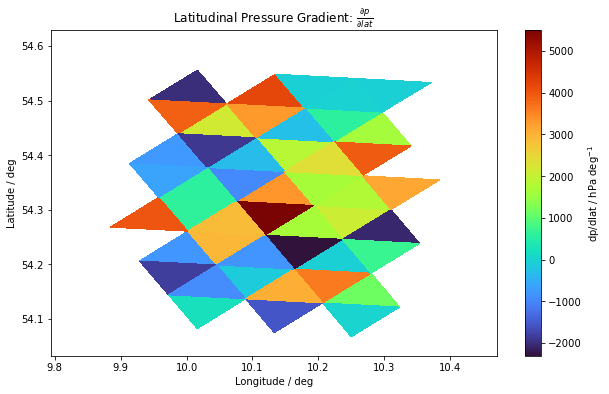

In [11]:
dpdlat_sfc = dpdlat[9, :]

fig, ax = plt.subplots(figsize=(10, 6))
im = plt.tripcolor(dvlon, dvlat, dvoc, dpdlat_sfc, cmap=plt.cm.get_cmap("turbo"))
cbar = fig.colorbar(im)

cbar.set_label("dp/dlat / hPa deg$^{-1}$")
ax.set_title(r"Latitudinal Pressure Gradient: $\frac{\partial p}{\partial lat}$")
ax.set_xlabel("Longitude / deg")
ax.set_ylabel("Latitude / deg")

plt.show()

In fact, it is difficult to tell with the naked eye whether our `derivative()` function did what we wanted it to do. For this reason you can see in [Part 2: Verification of Derivative Function](test_derivative.ipynb) a test example with the same function. Have fun !

Interesting side note: we compare below the initial pressure field on which our calculations are based with the calculated one. For this purpose, we plot the surface pressure field and see the initial pressure field from the simulation output on the left, the averaged pressure field based on the pressure values of the respective neighboring cells in the center and their difference to the right. <br>
Two things are remarkable:

1) The pressure fields are almost but not exactly equal. This is because the averaged values do not necessarily have to match the initial values for physical reasons.

2) Since we only calculate the pressure gradient for cells that have exactly three neighbors, the initial pressure field shrinks. The border cells of our window are truncated. This is especially important when averaging over the window and all cells afterwards. If we then compare averaged gradient fields with averaged non-gradient fields, we run the risk of comparing areas of different size. If, for example, the sea surface temperature is to be compared with the overlying pressure gradient field on average, the SST field may only contain as many cells as the gradient field; i.e. only those cells that have exactly three neighbors.

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
p0_sfc = p0[9, :] / 100  # selecting surface layer and converting into [hPa].

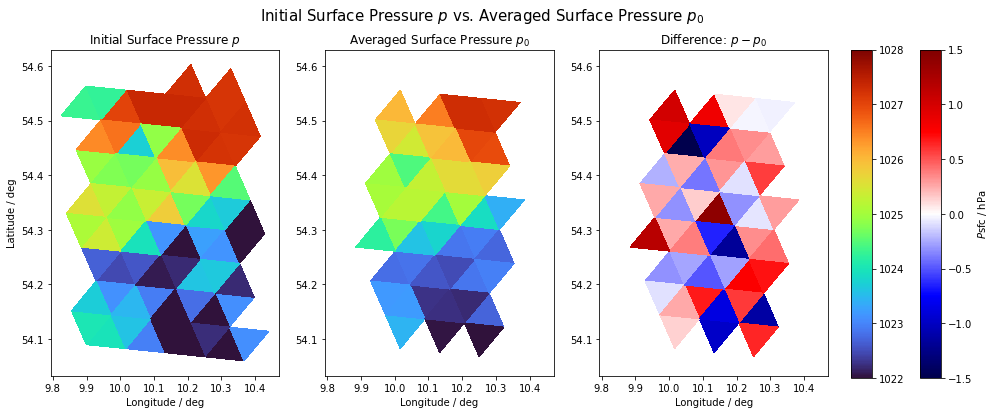

In [14]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle(
    "Initial Surface Pressure $p$ vs. Averaged Surface Pressure $p_0$", fontsize=15
)
ax = fig.subplots(1, 3)

ax[0].tripcolor(
    vlon, vlat, voc, p_data, cmap=plt.cm.get_cmap("turbo"), vmin=1022, vmax=1028
)
ax[0].set_title(f"Initial Surface Pressure $p$")
ax[0].set_xlabel("Longitude / deg")
ax[0].set_ylabel("Latitude / deg")

im = ax[1].tripcolor(
    dvlon, dvlat, dvoc, p0_sfc, cmap=plt.cm.get_cmap("turbo"), vmin=1022, vmax=1028
)
ax[1].set_title("Averaged Surface Pressure $p_0$")
ax[1].set_xlabel("Longitude / deg")

im1 = ax[2].tripcolor(
    dvlon,
    dvlat,
    dvoc,
    p_data[valid] - p0_sfc,
    cmap=plt.cm.get_cmap("seismic"),
    vmin=-1.5,
    vmax=1.5,
)
ax[2].set_title("Difference: $p-p_0$")
ax[2].set_xlabel("Longitude / deg")

fig.subplots_adjust(right=0.8)
cbar = fig.add_axes([0.82, 0.12, 0.018, 0.76])
cbar1 = fig.add_axes([0.88, 0.12, 0.018, 0.76])
fig.colorbar(im, cax=cbar)
fig.colorbar(im1, cax=cbar1, label="$P\mathrm{sfc}$ / hPa")

plt.show()